In [1]:
import pandas as pd
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("sonar.all-data", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [3]:
df.shape

(208, 61)

In [4]:
df[60].value_counts()

M    111
R     97
Name: 60, dtype: int64

In [5]:
df[60]= df[60].map({'M':0,'R':1})
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,1
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,1
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,1
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,1
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,1


In [10]:
X = df.drop(60,axis=1)
y = df[60]

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25, random_state=1)

In [11]:
# converting these split into tensors

X_train_tensor = torch.tensor(X_train.values,dtype= torch.float32)
y_train_tensor = torch.tensor(y_train.values,dtype= torch.long)
X_test_tensor = torch.tensor(X_test.values,dtype= torch.float32)
y_test_tensor = torch.tensor(y_test.values,dtype= torch.long)

In [12]:
# tensor datasets

train_dataset = TensorDataset(X_train_tensor,y_train_tensor)
test_dataset =  TensorDataset(X_test_tensor,y_test_tensor)

# data loaders

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [13]:
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(60,120),
            nn.ReLU(),
            nn.Linear(120,64),
            nn.ReLU(),
            nn.Linear(64,2)
        )
    def forward(self,x):
        return self.network(x)

In [14]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    train_losses, val_losses, val_accuracies = [], [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        y_pred, y_true = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                y_pred.extend(predicted.cpu().numpy())
                y_true.extend(labels.cpu().numpy())
        val_losses.append(val_loss / len(val_loader))
        val_accuracy = accuracy_score(y_true, y_pred)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    return train_losses, val_losses, val_accuracies

In [15]:
# Initialize and train the model without l2
model_without_l2 = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_without_l2.parameters(), lr=0.001)

train_losses_no_l2, val_losses_no_l2, val_accuracies_no_l2 = train_model(
    model_without_l2, train_loader, test_loader, criterion, optimizer, epochs=20
)

Epoch 1/20, Train Loss: 0.6948, Val Loss: 0.6672, Val Accuracy: 0.5192
Epoch 2/20, Train Loss: 0.6808, Val Loss: 0.6584, Val Accuracy: 0.5192
Epoch 3/20, Train Loss: 0.6636, Val Loss: 0.6392, Val Accuracy: 0.5192
Epoch 4/20, Train Loss: 0.6469, Val Loss: 0.6176, Val Accuracy: 0.6538
Epoch 5/20, Train Loss: 0.6214, Val Loss: 0.6122, Val Accuracy: 0.7885
Epoch 6/20, Train Loss: 0.6010, Val Loss: 0.5699, Val Accuracy: 0.6923
Epoch 7/20, Train Loss: 0.5536, Val Loss: 0.5756, Val Accuracy: 0.7885
Epoch 8/20, Train Loss: 0.5138, Val Loss: 0.5266, Val Accuracy: 0.7500
Epoch 9/20, Train Loss: 0.4895, Val Loss: 0.5712, Val Accuracy: 0.7308
Epoch 10/20, Train Loss: 0.4568, Val Loss: 0.5088, Val Accuracy: 0.7500
Epoch 11/20, Train Loss: 0.4338, Val Loss: 0.4856, Val Accuracy: 0.7115
Epoch 12/20, Train Loss: 0.4091, Val Loss: 0.5115, Val Accuracy: 0.7500
Epoch 13/20, Train Loss: 0.3919, Val Loss: 0.5086, Val Accuracy: 0.7308
Epoch 14/20, Train Loss: 0.3793, Val Loss: 0.4871, Val Accuracy: 0.7885
E

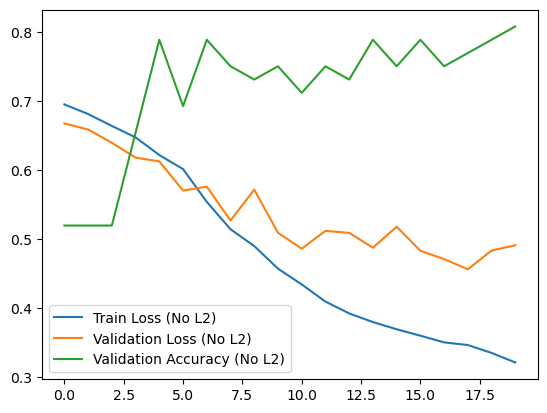

In [16]:
plt.plot(train_losses_no_l2, label="Train Loss (No L2)")
plt.plot(val_losses_no_l2, label="Validation Loss (No L2)")
plt.plot(val_accuracies_no_l2, label="Validation Accuracy (No L2)")
plt.legend()
plt.show()

In [17]:
# Initialize and train the modelwith l2
model_with_l2 = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_with_l2.parameters(), lr=0.001,weight_decay=0.04)

train_losses_with_l2, val_losses_with_l2, val_accuracies_with_l2 = train_model(
    model_with_l2, train_loader, test_loader, criterion, optimizer, epochs=20
)

Epoch 1/20, Train Loss: 0.6881, Val Loss: 0.6794, Val Accuracy: 0.5192
Epoch 2/20, Train Loss: 0.6857, Val Loss: 0.6733, Val Accuracy: 0.5192
Epoch 3/20, Train Loss: 0.6825, Val Loss: 0.6727, Val Accuracy: 0.5192
Epoch 4/20, Train Loss: 0.6818, Val Loss: 0.6723, Val Accuracy: 0.5192
Epoch 5/20, Train Loss: 0.6808, Val Loss: 0.6698, Val Accuracy: 0.5192
Epoch 6/20, Train Loss: 0.6793, Val Loss: 0.6683, Val Accuracy: 0.5192
Epoch 7/20, Train Loss: 0.6781, Val Loss: 0.6648, Val Accuracy: 0.5192
Epoch 8/20, Train Loss: 0.6762, Val Loss: 0.6628, Val Accuracy: 0.5192
Epoch 9/20, Train Loss: 0.6751, Val Loss: 0.6600, Val Accuracy: 0.5192
Epoch 10/20, Train Loss: 0.6718, Val Loss: 0.6589, Val Accuracy: 0.5192
Epoch 11/20, Train Loss: 0.6700, Val Loss: 0.6531, Val Accuracy: 0.5192
Epoch 12/20, Train Loss: 0.6656, Val Loss: 0.6508, Val Accuracy: 0.5962
Epoch 13/20, Train Loss: 0.6613, Val Loss: 0.6443, Val Accuracy: 0.6346
Epoch 14/20, Train Loss: 0.6532, Val Loss: 0.6386, Val Accuracy: 0.6731
E

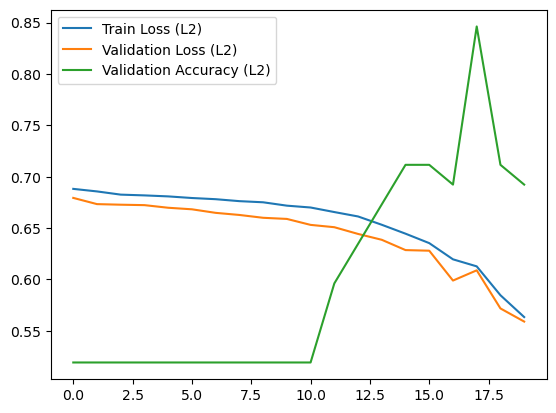

In [19]:
plt.plot(train_losses_with_l2, label="Train Loss (L2)")
plt.plot(val_losses_with_l2, label="Validation Loss (L2)")
plt.plot(val_accuracies_with_l2, label="Validation Accuracy (L2)")
plt.legend()
plt.show()